In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Custom dataset
import requests
import zipfile
from pathlib import Path
import os

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # download pizza, steak, sushi data
  
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(req.content)
  
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

  # remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi does not exist, creating one...


In [6]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  
  Args:
      dir_path (str): target directory
  """
  
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

In [21]:
!tree ./data/pizza_steak_sushi/ --du -h --filelimit 4 --noreport

[ 36K]  ./data/pizza_steak_sushi/
├── [ 16K]  test
│   ├── [4.0K]  pizza  [25 entries exceeds filelimit, not opening dir]
│   ├── [4.0K]  steak  [19 entries exceeds filelimit, not opening dir]
│   └── [4.0K]  sushi  [31 entries exceeds filelimit, not opening dir]
└── [ 16K]  train
    ├── [4.0K]  pizza  [78 entries exceeds filelimit, not opening dir]
    ├── [4.0K]  steak  [75 entries exceeds filelimit, not opening dir]
    └── [4.0K]  sushi  [72 entries exceeds filelimit, not opening dir]


In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [28]:
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths (* means 'any extension')
image_files = list(image_path.glob("**/*.jpg"))
print(len(image_files)) # 25 + 31 + 19 + 78 + 72 + 75 = 300
image_files[:5]

300


[PosixPath('data/pizza_steak_sushi/train/steak/3727491.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614649.jpg')]

Width, Height: (512, 512)
Image path: data/pizza_steak_sushi/train/pizza/2382016.jpg


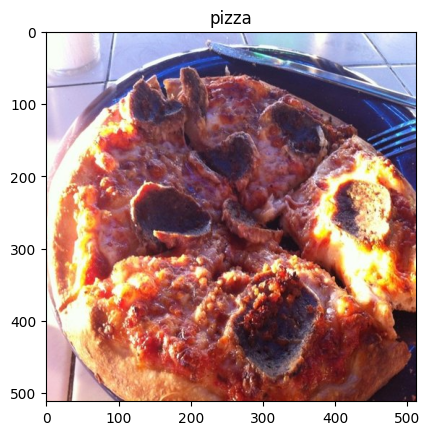

In [38]:
import matplotlib.pyplot as plt
random_image = random.choice(image_files)

# 2. Open image
img = Image.open(random_image)
print("Width, Height:", img.size)
print("Image path:", random_image)
plt.title(random_image.parent.stem) # same as str(random_image.parent).split("/")[-1]
plt.imshow(img)

(512, 512, 3)


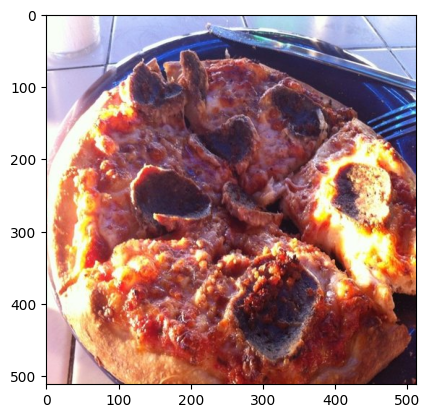

In [42]:
import numpy as np

# turn the image into array
img_arr = np.asarray(img)
print(img_arr.shape)
plt.imshow(img_arr)

#### Data transformation

1. data (images) -> tensors
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [44]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [53]:
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  # Flip the image horizontally
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

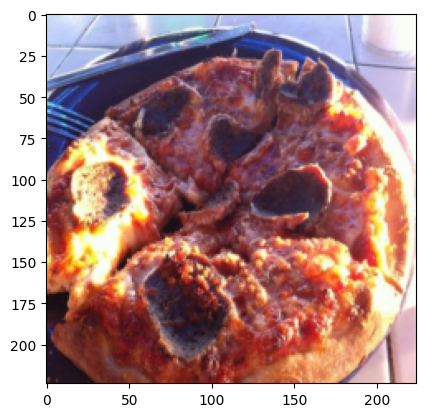

In [54]:
transformed_image = train_transform(img)
plt.imshow(transformed_image.permute(1, 2, 0))

In [89]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Plots `n` random images from `image_paths`

  Args:
    image_paths (list): List of target image paths
    transform (PyTorch Transforms): image transformation
    n (int, optional): Total number of images to plot
    seed (int, optional): Random seed
  """
  random.seed(seed)
  # random image path
  random_image_path = random.sample(image_paths, n)
  for image in random_image_path:
    # open image
    with Image.open(image) as img:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(img)
      ax[0].set_title(f"Original\nSize: {img.size}")
      ax[0].axis(False)
      transformed_image = transform(img)
      
      ax[1].imshow(transformed_image.permute(1, 2, 0))
      ax[1].set_title(f"Transformed\nSize: {tuple(transformed_image.shape[1:])}")
      ax[1].axis(False)
      
      fig.suptitle(f"Class: {image.parent.stem}", fontsize=12)
      fig.tight_layout()


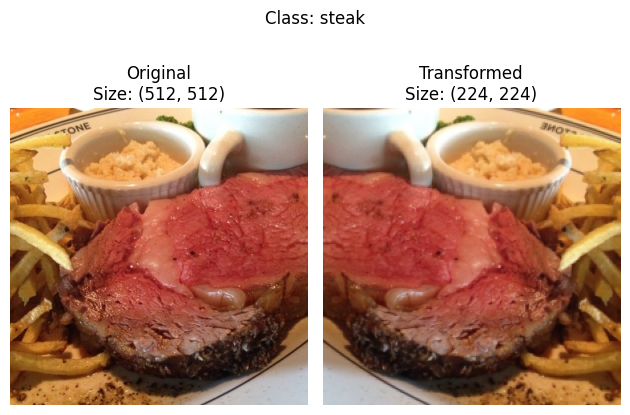

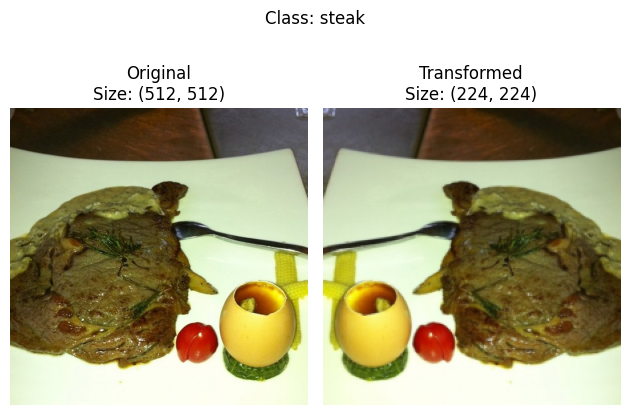

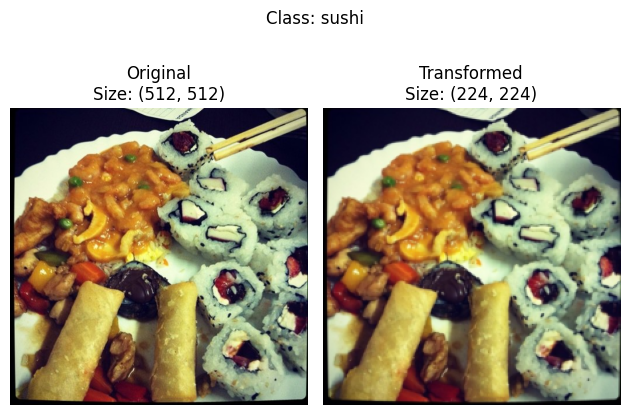

In [90]:
plot_transformed_images(image_files, train_transform, n=3)

In [92]:
# image_path = Path("data/pizza_steak_sushi/")
train_dir = image_path / "train"
test_dir = image_path / "test"

# ImageFolder requires a specific directory structure:
# ./path/to/dataset_directory/
# ├── test
# │   ├── label_1_test_data
# │   ├── label_2_test_data
# │   ├── label_3_test_data
# │   └── ...
# └── train
#     ├── label_1_train_data
#     ├── label_2_train_data
#     ├── label_3_train_data
#     └── ...
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # transform for the data
                                  target_transform=None # transform for the labels
                                )
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

In [93]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [94]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [96]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [101]:
print(len(train_data), len(test_data))
print(train_data.samples[0], "->", class_names[0]) # tuple of (image_path, label)

225 75
('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0) -> pizza


In [107]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
         ...,
         [0.1804, 0.1725, 0.1725,  ..., 0.0863, 0.0902, 0.0941],
         [0.1686, 0.1686, 0.1647,  ..., 0.0902, 0.0902, 0.0902],
         [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
         [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
         [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0784, 0.0706],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
         [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.09

torch.Size([224, 224, 3])


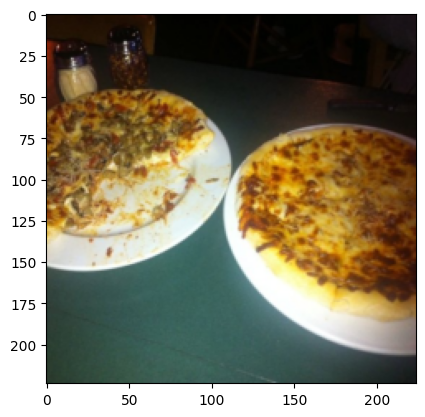

In [108]:
# Rearrange the oreder of dimensions
img_permuted = img.permute((1, 2, 0)) # [C, H, W] -> [H, W, C]
print(img_permuted.shape)
plt.imshow(img_permuted)

In [110]:
# turn loaded data into a DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
  train_data, 
  batch_size=BATCH_SIZE, 
  shuffle=True,
  num_workers=os.cpu_count() # how many CPU cores to use (to load data in parallel)
)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [111]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [112]:
img, label = next(iter(train_dataloader))
print(img.shape, label.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
